# Import Libraries

In [1]:
# Import general libraries
import numpy as np
import os
import PIL
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

# Import Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Importation

For training and validation, we will make use of a dataset obtained from Kaggle. The training set contains approximately 400 paintings from 10 artists in the Impressionist movement, most notably including Vincent van Gogh, Henri Matisse, and Claude Monet. The validation set is comprised of the same set of artists, but containing only approximately 100 paintings per artist.

As we have only about 400 images per artist in the training dataset, we may have to make use of data augmentation to increase the number of images for training the model, as it may overfit on the former.

In [2]:
# Load the data using TensorFlow
train_dir = '/content/drive/MyDrive/Kaggle/training'
validation_dir = '/content/drive/MyDrive/Kaggle/validation'

img_size = 224

# Perform some data augmentation on the training set to artificially
# increase training dataset size
train_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 45,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = 'nearest')

train_set = train_gen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    batch_size = 400,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)

# Load the validation dataset with TensorFlow

validation_gen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_gen.flow_from_directory(
    validation_dir,
    color_mode = 'rgb',
    batch_size = 99,
    target_size = (img_size, img_size),
    class_mode = 'categorical',
    seed = 123)

Found 4158 images belonging to 10 classes.
Found 990 images belonging to 10 classes.


# Model 1

The first model we will train is VGG-16. VGG-16 is a convolutional neural network proposed by K. Simonyan and A. Zisserman, both from Oxford. The model was trained on ImageNet, a dataset with over 14 million images belonging to aver 1000 classes.

As such VGG-16 will be an excellent launching point for transfer learning.

In [3]:
# Import VGG-16
from tensorflow.keras.applications.vgg16 import VGG16

# Define the base model, leaving out the last fully connected layer
base_model = VGG16(input_shape = (img_size, img_size, 3),
                   include_top = False,
                   weights = 'imagenet')

# As we needn't train every layer, we can make them non-trainable
for layer in base_model.layers:

    layer.trainable = False

In [4]:
# Now to construct the final fully-connected layer.

# Flatten the output layer to one dimension
x = layers.Flatten()(base_model.output)

# Now add a fully-connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation = 'relu')(x)

# Add a dropout layer with rate 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 1 node for classification output
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [5]:
vgghist = model.fit(train_set, batch_size = 20, validation_data= validation_set,
                    validation_steps = 8, steps_per_epoch = 20, epochs = 10, 
                    workers = 10, use_multiprocessing = True)

Epoch 1/10
20/20 [==============================] - 351s 10s/step - loss: 2.5665 - accuracy: 0.2026 - val_loss: 1.9318 - val_accuracy: 0.3384
Epoch 2/10
20/20 [==============================] - 315s 10s/step - loss: 1.9423 - accuracy: 0.3136 - val_loss: 1.7984 - val_accuracy: 0.3725
Epoch 3/10
20/20 [==============================] - 313s 9s/step - loss: 1.8376 - accuracy: 0.3662 - val_loss: 1.7112 - val_accuracy: 0.3851
Epoch 4/10
20/20 [==============================] - 328s 10s/step - loss: 1.7567 - accuracy: 0.3812 - val_loss: 1.6759 - val_accuracy: 0.4091
Epoch 5/10
20/20 [==============================] - 310s 9s/step - loss: 1.7165 - accuracy: 0.3945 - val_loss: 1.5944 - val_accuracy: 0.4596
Epoch 6/10
20/20 [==============================] - 311s 9s/step - loss: 1.6731 - accuracy: 0.4147 - val_loss: 1.4940 - val_accuracy: 0.5025
Epoch 7/10
20/20 [==============================] - 313s 9s/step - loss: 1.6263 - accuracy: 0.4307 - val_loss: 1.5596 - val_accuracy: 0.4823
Epoch 8/10

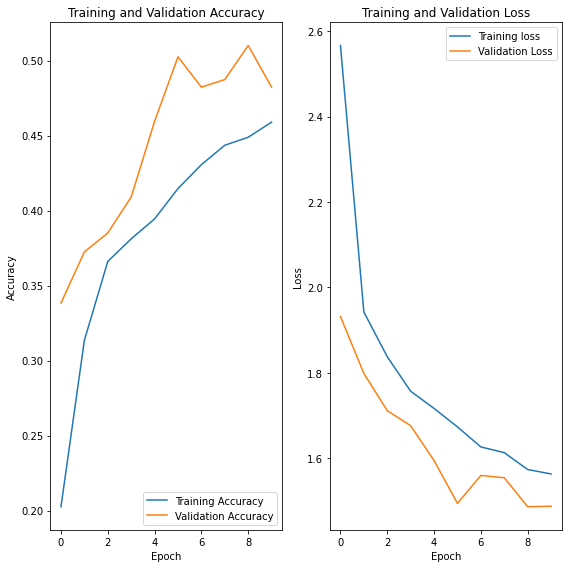

In [6]:
acc = vgghist.history['accuracy']
val_acc = vgghist.history['val_accuracy']

loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

epochs_range = range(10)

# Output graphs displaying loss vs epoch and accuracy vs epoch

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

# Save the figure
plt.savefig("VGG16_loss+acc.png")

plt.tight_layout()
plt.show()

Given the above plots, there are a few things to notice:

1. 10 epochs is perhaps not enough time for the model to converge upon a minimum value for the loss function

2. For most of the epochs, validation accuracy exceeds training accuracy by a few percentage points

3. The model achieves an accuracy of 48.23% in the validation set; it's slightly worse than flipping a coin

4. The runtime for training VGG-16 was approximately 1 hour, so hopefully this can be either be improved upon or another model must be selected for transfer learning.

# Model 2

The second model we will train is VGG-19, a more recent version of the previous model.

In [7]:
# Import VGG-19
from tensorflow.keras.applications.vgg19 import VGG19

# Define the base model
base_model = VGG19(input_shape = (img_size, img_size, 3),
                   include_top = False,
                   weights = 'imagenet')

# As we needn't train every layer, we can make them non-trainable
for layer in base_model.layers:

    layer.trainable = False

In [8]:
# Add the final fully connected layers: Flatten, Dense, Dropout, Dense

# Flatten the output
x = layers.Flatten()(base_model.output)

# Dense layer with 
x = layers.Dense(512, activation = 'relu')(x)

# Add a dropout layer
x = layers.Dropout(0.5)(x)

# Output layer with Softmax as the activation function
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [9]:
# Train the model and evaluate performance metrics
vgg19hist = model.fit(train_set, batch_size = 20, validation_data= validation_set,
                      validation_steps = 8, steps_per_epoch = 20, epochs = 10, 
                      workers = 10, use_multiprocessing = True)

Epoch 1/10
20/20 [==============================] - 303s 9s/step - loss: 2.7911 - accuracy: 0.1811 - val_loss: 1.9873 - val_accuracy: 0.3030
Epoch 2/10
20/20 [==============================] - 309s 10s/step - loss: 2.0133 - accuracy: 0.2721 - val_loss: 1.9017 - val_accuracy: 0.2967
Epoch 3/10
20/20 [==============================] - 293s 9s/step - loss: 1.9415 - accuracy: 0.3076 - val_loss: 1.8590 - val_accuracy: 0.3220
Epoch 4/10
20/20 [==============================] - 293s 9s/step - loss: 1.8961 - accuracy: 0.3256 - val_loss: 1.7932 - val_accuracy: 0.3573
Epoch 5/10
20/20 [==============================] - 297s 9s/step - loss: 1.8375 - accuracy: 0.3546 - val_loss: 1.7259 - val_accuracy: 0.4003
Epoch 6/10
20/20 [==============================] - 296s 9s/step - loss: 1.7918 - accuracy: 0.3705 - val_loss: 1.7179 - val_accuracy: 0.3939
Epoch 7/10
20/20 [==============================] - 311s 10s/step - loss: 1.7543 - accuracy: 0.3881 - val_loss: 1.6990 - val_accuracy: 0.4028
Epoch 8/10


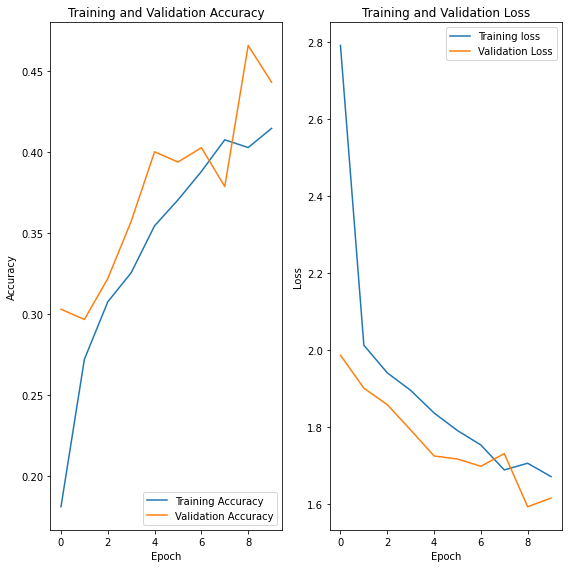

In [10]:
# Plot loss and accuracy vs epoch for training and validation 

loss = vgg19hist.history['loss']
val_loss = vgg19hist.history['val_loss']

acc = vgg19hist.history['accuracy']
val_acc = vgg19hist.history['val_accuracy']

# Output graphs displaying loss vs epoch and accuracy vs epoch

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

# Save the figure
plt.savefig("VGG19_loss+acc.png")

plt.tight_layout()
plt.show()

Some Notes:

1. This model performed marginally worse than the previous VGG neural network model in both learning curves. 

2. The model achieved an accuracy score of 41.47% and 44.32% in the training and validation datasets, which is worse than those of VGG-16.

3. The loss and accuracy curves for the validation dataset exhibit some minor erratic behavior, indicating that the learning rate may need to be lowered so as to reach global or local minima.

# Model 3

The second model we will train for transfer learning is Inception

In [11]:
# Import the base model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Define the base model
base_model = InceptionV3(input_shape = (img_size, img_size, 3), 
                          include_top = False,
                          weights = 'imagenet')

for layer in base_model.layers:

    layer.trainable = False

In [12]:
# Import the RMSprop and Adam optimizers
from tensorflow.keras.optimizers import RMSprop, Adam

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 10 nodes for classification
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Compile the model
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
                                  loss = 'categorical_crossentropy',
                                  metrics = ['accuracy'])

In [14]:
# Now we will train the model
inc_history = model.fit(train_set, validation_data = validation_set, batch_size = 20,
                        steps_per_epoch = 20, epochs = 10, workers = 10, 
                        validation_steps = 8, use_multiprocessing = True)

Epoch 1/10
20/20 [==============================] - 321s 10s/step - loss: 6.6669 - accuracy: 0.1891 - val_loss: 2.0814 - val_accuracy: 0.2753
Epoch 2/10
20/20 [==============================] - 309s 9s/step - loss: 2.0852 - accuracy: 0.2676 - val_loss: 2.0441 - val_accuracy: 0.3030
Epoch 3/10
20/20 [==============================] - 307s 13s/step - loss: 2.0385 - accuracy: 0.2983 - val_loss: 1.9800 - val_accuracy: 0.3018
Epoch 4/10
20/20 [==============================] - 288s 9s/step - loss: 1.8933 - accuracy: 0.3419 - val_loss: 1.7961 - val_accuracy: 0.3876
Epoch 5/10
20/20 [==============================] - 302s 9s/step - loss: 1.8225 - accuracy: 0.3704 - val_loss: 1.7862 - val_accuracy: 0.3712
Epoch 6/10
20/20 [==============================] - 286s 8s/step - loss: 1.7855 - accuracy: 0.3865 - val_loss: 1.6012 - val_accuracy: 0.4571
Epoch 7/10
20/20 [==============================] - 300s 13s/step - loss: 1.7184 - accuracy: 0.4119 - val_loss: 1.7492 - val_accuracy: 0.3750
Epoch 8/10

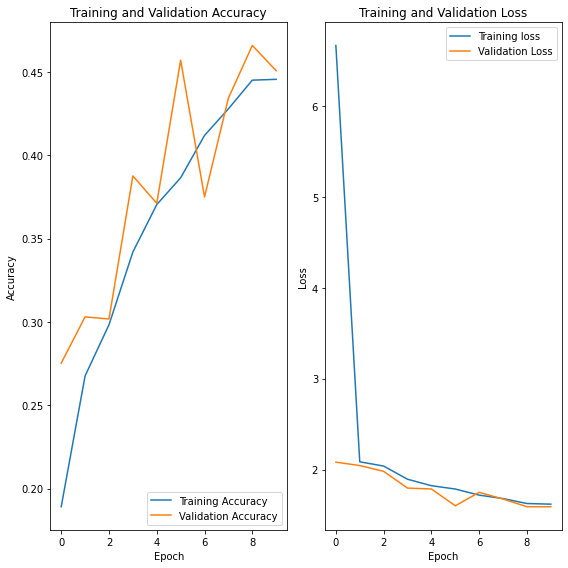

In [15]:
# Output and save accuracy and loss plots

acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs_range = range(10)

# Output graphs displaying loss vs epoch and accuracy vs epoch

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

# Save the figure
plt.savefig("InceptionV3_loss+acc.png")

plt.tight_layout()
plt.show()

Some notes from the above graphs:

1. Model performance was relatively worse than the previous two models, however, the learning curves do indicate that more training time (epochs) may be beneficial for overall accuracy

2. Learning rate requires some adjustment during training as there are some jumps in the loss learning curve

3. Additional parameters that may be adjusted include the optimizer, the dropout rate, and the number of units in the first fully-connected layer

# Model 4

We'll build another Inception model but with a lower dropout rate  

In [16]:
# Define the base model
base_model = InceptionV3(input_shape = (img_size, img_size, 3), 
                          include_top = False,
                          weights = 'imagenet')

for layer in base_model.layers:

    layer.trainable = False

In [17]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.25)(x)

# Add a final softmax layer with 10 nodes for classification
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Compile the model
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
                                  loss = 'categorical_crossentropy',
                                  metrics = ['accuracy'])

In [18]:
# Now we will train the model
inc2_history = model.fit(train_set, validation_data = validation_set, batch_size = 20,
                        steps_per_epoch = 20, epochs = 10, workers = 10, 
                        validation_steps = 8, use_multiprocessing = True)

Epoch 1/10
20/20 [==============================] - 297s 9s/step - loss: 8.6701 - accuracy: 0.1714 - val_loss: 2.1585 - val_accuracy: 0.2399
Epoch 2/10
20/20 [==============================] - 290s 9s/step - loss: 2.0663 - accuracy: 0.2873 - val_loss: 1.9947 - val_accuracy: 0.3182
Epoch 3/10
20/20 [==============================] - 290s 9s/step - loss: 2.0988 - accuracy: 0.2732 - val_loss: 2.2389 - val_accuracy: 0.2727
Epoch 4/10
20/20 [==============================] - 304s 9s/step - loss: 1.9499 - accuracy: 0.3208 - val_loss: 1.8602 - val_accuracy: 0.3586
Epoch 5/10
20/20 [==============================] - 304s 9s/step - loss: 1.7723 - accuracy: 0.3865 - val_loss: 1.7908 - val_accuracy: 0.3838
Epoch 6/10
20/20 [==============================] - 291s 9s/step - loss: 1.7969 - accuracy: 0.3815 - val_loss: 1.7031 - val_accuracy: 0.4217
Epoch 7/10
20/20 [==============================] - 289s 8s/step - loss: 1.6982 - accuracy: 0.4163 - val_loss: 1.6630 - val_accuracy: 0.4520
Epoch 8/10
20

# Model 5

In [20]:
# Import ResNet50 from TensorFlow
from tensorflow.keras.applications.resnet50 import ResNet50

# Define the base model
base_model = ResNet50(input_shape = (img_size, img_size, 3),
                      include_top = False, 
                      weights = 'imagenet', 
                      pooling = 'avg')

for layer in base_model.layers:

    layer.trainable = False

In [21]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 10 nodes for classification
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                                  loss = 'categorical_crossentropy',
                                  metrics = ['accuracy'])

In [22]:
# Train the model
resnet_history = model.fit(train_set, batch_size = 20, shuffle = True, 
                          validation_data= validation_set, validation_steps = 8, 
                          steps_per_epoch = 20, epochs = 10,
                          workers = 10, use_multiprocessing = True)

Epoch 1/10
20/20 [==============================] - 315s 10s/step - loss: 2.5695 - accuracy: 0.1122 - val_loss: 2.2786 - val_accuracy: 0.1136
Epoch 2/10
20/20 [==============================] - 305s 9s/step - loss: 2.4249 - accuracy: 0.1140 - val_loss: 2.2708 - val_accuracy: 0.1199
Epoch 3/10
20/20 [==============================] - 288s 9s/step - loss: 2.3465 - accuracy: 0.1275 - val_loss: 2.2456 - val_accuracy: 0.1351
Epoch 4/10
20/20 [==============================] - 287s 13s/step - loss: 2.2921 - accuracy: 0.1345 - val_loss: 2.2442 - val_accuracy: 0.1351
Epoch 5/10
20/20 [==============================] - 302s 9s/step - loss: 2.2627 - accuracy: 0.1460 - val_loss: 2.2328 - val_accuracy: 0.1351
Epoch 6/10
20/20 [==============================] - 289s 9s/step - loss: 2.2438 - accuracy: 0.1553 - val_loss: 2.2235 - val_accuracy: 0.1326
Epoch 7/10
20/20 [==============================] - 289s 9s/step - loss: 2.2301 - accuracy: 0.1678 - val_loss: 2.2098 - val_accuracy: 0.1490
Epoch 8/10


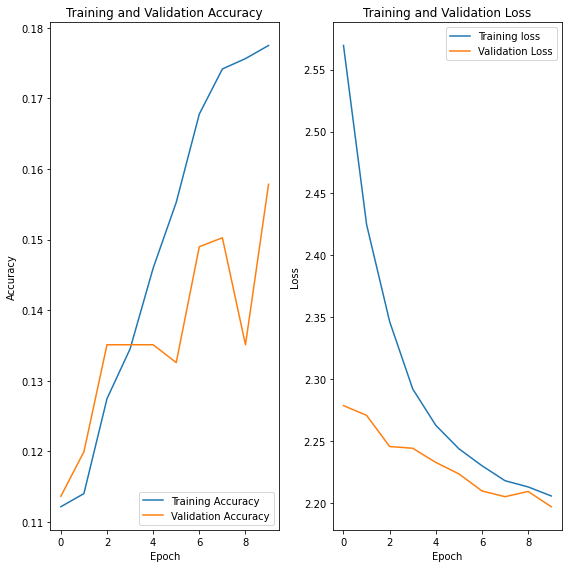

In [23]:
# Output and save accuracy and loss plots

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(10)

# Output graphs displaying loss vs epoch and accuracy vs epoch

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

# Save the figure
plt.savefig("ResNet50_loss+acc.png")

plt.tight_layout()
plt.show()

Some notes:

1. Firstly, this model's performance is substantially worse than the prior models; < 20% accuracy in both the training and validation datasets

2. The model is overfitting (training accuracy exceeds validation accuracy by a wide margin)

3. The loss function does decrease in both datasets, however, it does not exhibit a dramatic decrease prior to a plateau like the other models

4. Given the above points, it may be likely that ResNet50 is too complex an architecture for the dataset we have at hand

# Hyperparameter Tuning

Although VGG19 performed better in the training and validation datasets than Inception, the accuracy and loss curves exhibited very erratic behavior. As such, we will proceed with Inception for hyperparameter tuning 

There are a few things to note:

1. This model did perform better than the Inception model we had trained previously; It reached an accuracy score of 60.75% and 58.70% in the training and validation datasets, respectively.

2. The learning rate may potentially be too small, as the decreases in the loss function did become progressively smaller over time.

3. Although this model is relatively better, the model may still be too complex architecturally, given that the training and validation accuracies are low. Reducing the number of units in the first fully-connected layer and increasing the dropout rate may help

# Hyperparameters 2

In [7]:
# Construct a new set of output layers for a new model

from tensorflow.keras.applications.vgg19 import VGG19

base_model2 = InceptionV3(input_shape = (img_size, img_size, 3),
                          include_top = False,
                          pooling = 'avg')

for layer in base_model2.layers:

    layer.trainable = False

# Import the RMSprop and Adam optimizers
from tensorflow.keras.optimizers import RMSprop, Adam

x = layers.Flatten()(base_model2.output)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(10, activation = 'softmax')(x)
 
model2 = tf.keras.models.Model(base_model2.input, x)

#Import and define callback functions to adjust learning rate based upon performance
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                              patience = 1, min_lr = 0.0001)

# Compile the above model with the Adam optimizer and a learning rate of 0.001
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# Now we can train the model
inc_hist2 = model2.fit(train_set, batch_size= 20, epochs = 50,
                     validation_data = validation_set,
                     shuffle = True, steps_per_epoch = 20,
                     validation_steps = 9, workers = 10,
                     callbacks = reduce_lr,
                     use_multiprocessing = True)

Epoch 1/50
20/20 [==============================] - 292s 9s/step - loss: 1.7293 - accuracy: 0.4063 - val_loss: 1.6927 - val_accuracy: 0.4433
Epoch 2/50
20/20 [==============================] - 290s 9s/step - loss: 1.6014 - accuracy: 0.4470 - val_loss: 1.6274 - val_accuracy: 0.4501
Epoch 3/50
20/20 [==============================] - 290s 9s/step - loss: 1.5524 - accuracy: 0.4651 - val_loss: 1.5252 - val_accuracy: 0.4882
Epoch 4/50
20/20 [==============================] - 299s 9s/step - loss: 1.4956 - accuracy: 0.4831 - val_loss: 1.5330 - val_accuracy: 0.4770
Epoch 5/50
20/20 [==============================] - 287s 9s/step - loss: 1.4491 - accuracy: 0.4915 - val_loss: 1.4919 - val_accuracy: 0.4927
Epoch 6/50
20/20 [==============================] - 302s 9s/step - loss: 1.4158 - accuracy: 0.5102 - val_loss: 1.4922 - val_accuracy: 0.4927
Epoch 7/50
20/20 [==============================] - 286s 9s/step - loss: 1.4065 - accuracy: 0.5174 - val_loss: 1.4944 - val_accuracy: 0.4860
Epoch 8/50
20